In [0]:


#                              CLASSIFICATION (PREPROCESSING AND MIXED)


#***********************************IMPORTS*************************************


# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
from google.colab import drive
import sys
import os



drive.mount('/content/gdrive', force_remount=True)
project_path = "/content/gdrive/My Drive/shared/Colab Notebooks/tesi/models"           #PATH NEED TO BE CHANGED ACCORDING TO THE LOCATION OF THE PROJECT
data_path = "/content/gdrive/My Drive/shared/Colab Notebooks/tesi/data/"
weights_path = project_path + '/weights/'
sys.path.append(project_path)

from evaluation_utilities import *
from data_utilities import *
from net_utilities import *


#*******************************************************************************

In [0]:
#************************************PARAMS*************************************


n_classes = 169
batch_size = 128
random_seed = 1995
n_epoch = 1999
input_size = (28, 28, 1)
mode = "mixed" # mixed | prepreocess

np.random.seed(seed=random_seed)
tf.random.set_seed(seed=random_seed)

#*******************************************************************************

In [0]:
#******************************DATA PROCESSING**********************************


print("loading data...")


# **** load draws ****
(X_draws, y_string_draws) = load_data(data_path + "/draws-28.pickle", size=input_size[0], _3d=False, invert=False, randomize=False, rand_seed=random_seed)

# **** load icons ****
(X_icons, y_string_icons) = load_data(data_path + "/icons-28.pickle", size=input_size[0], _3d=False, invert=False, randomize=False, rand_seed=random_seed)


# **** check datasets classes ****
X_draws, X_icons, y_string_draws, y_string_icons = check_dataset_classes(X_draws, X_icons, y_string_draws, y_string_icons)


# **** preprocess  draws ****
x_train_draws, x_valid_draws, x_test_draws, y_train_draws, y_valid_draws, y_test_draws = split_dataset(X_draws, y_string_draws, _validation_size=0.2, _test_size=0.1, _random_seed=random_seed, stratify=True)
y_train_draws, y_valid_draws, y_test_draws = labels_preprocessing(y_train_draws, y_valid_draws, y_test_draws)
x_train_draws, y_train_draws = shuffle_with_same_indexes(x_train_draws, y_train_draws, seed=random_seed)
x_valid_draws, y_valid_draws = shuffle_with_same_indexes(x_valid_draws, y_valid_draws, seed=random_seed)
x_test_draws, y_test_draws = shuffle_with_same_indexes(x_test_draws, y_test_draws, seed=random_seed)
x_train_draws, x_valid_draws, x_test_draws = data_preprocessing(x_train_draws), data_preprocessing(x_valid_draws), data_preprocessing(x_test_draws)



# **** preprocess  icons ****
x_train_icons, x_valid_icons, x_test_icons, y_train_icons, y_valid_icons, y_test_icons = split_dataset(X_icons, y_string_icons, _validation_size=0.2, _test_size=0.1, _random_seed=random_seed, stratify=True)
y_train_icons, y_valid_icons, y_test_icons = labels_preprocessing(y_train_icons, y_valid_icons, y_test_icons)
x_train_icons, y_train_icons = shuffle_with_same_indexes(x_train_icons, y_train_icons, seed=random_seed)
x_valid_icons, y_valid_icons = shuffle_with_same_indexes(x_valid_icons, y_valid_icons, seed=random_seed)
x_test_icons, y_test_icons = shuffle_with_same_indexes(x_test_icons, y_test_icons, seed=random_seed)
x_train_icons, x_valid_icons, x_test_icons = data_preprocessing(x_train_icons), data_preprocessing(x_valid_icons), data_preprocessing(x_test_icons)



# **** check datasets ****
X_draws, X_icons, y_string_draws, y_string_icons = check_dataset_classes(X_draws, X_icons, y_string_draws, y_string_icons)
assert len(set(y_train_draws)) == n_classes, print("wrong class number")
assert len(set(y_train_icons)) == n_classes, print("wrong class number")

print("data loaded")

#*******************************************************************************

loading data...
datasets don't match
dataset matched
created: x_train:  (12168, 28, 28, 1)
created: x_valid:  (3042, 28, 28, 1)
created: x_test:  (1690, 28, 28, 1)
created: y_string_train:  (12168,)
created: y_string_valid:  (3042,)
created: y_string_test:  (1690,)
created: num classes:  169 169 169
created: x_train:  (12168, 28, 28, 1)
created: x_valid:  (3042, 28, 28, 1)
created: x_test:  (1690, 28, 28, 1)
created: y_string_train:  (12168,)
created: y_string_valid:  (3042,)
created: y_string_test:  (1690,)
created: num classes:  169 169 169
dataset matched
data loaded


In [0]:

# **** preprocess icons ****
if mode != "mixed":
  for _i, i in enumerate(x_train_icons): x_train_icons[_i] = contour_img(i)
  for _i, i in enumerate(x_valid_icons): x_valid_icons[_i] = contour_img(i)
  for _i, i in enumerate(x_test_icons): x_test_icons[_i] = contour_img(i)


In [0]:
# **** merge datasets ****

x_train = np.concatenate((x_train_draws, x_train_icons), axis=0)
x_valid = np.concatenate((x_valid_draws, x_valid_icons), axis=0)
x_test = np.concatenate((x_test_draws, x_test_icons), axis=0)

y_train = np.concatenate((y_train_draws, y_train_icons), axis=0)
y_valid = np.concatenate((y_valid_draws, y_valid_icons), axis=0)
y_test = np.concatenate((y_test_draws, y_test_icons), axis=0)

x_train, y_train = shuffle_with_same_indexes(x_train, y_train, seed=random_seed)
x_valid, y_valid = shuffle_with_same_indexes(x_valid, y_valid, seed=random_seed)
x_test, y_test = shuffle_with_same_indexes(x_test, y_test, seed=random_seed)


In [0]:

is_data_already_prepro = False if np.max(x_train[0]) > 1 else True
print("is data preprocessed? ", is_data_already_prepro)

custom_aug = CustomAug({
      'rescale': not is_data_already_prepro,        # if rescale == True, the alg assumes the data is in format 0-255
      'pad' : True,                           
      'horizontal_flip' : True,             
      'erosion' : True,                       
      'half_aug' : True,
    }
)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_aug.custom_preprocessing)
train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = datagen.flow(x_valid, y_valid, batch_size=batch_size)


is data preprocessed?  True


In [0]:
for i, im in enumerate(x_train):
  if i < 50:
    mm = custom_aug.custom_preprocessing(im)
    print(np.min(np.asarray(mm)), np.max(np.asarray(mm)), np.asarray(mm).shape)
    show_img(mm)

0.0032338062 1.0 (28, 28, 1)


0.09803922 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.022359896 1.0 (28, 28, 1)


0.1254902 1.0 (28, 28, 1)


0.09696816 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.021185128 1.0 (28, 28, 1)


0.064084075 1.0 (28, 28, 1)


0.036736645 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.30659193 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.054449357 1.0 (28, 28, 1)


0.03283976 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.00012466124 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.011764706 1.0 (28, 28, 1)


0.16084471 1.0 (28, 28, 1)


0.0009566682 1.0 (28, 28, 1)


0.09803922 1.0 (28, 28, 1)


0.0010062241 1.0 (28, 28, 1)


0.00015436465 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.05490196 1.0 (28, 28, 1)


0.031485695 1.0 (28, 28, 1)


0.066177614 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.06666667 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.04487468 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


0.16384673 1.0 (28, 28, 1)


0.0 1.0 (28, 28, 1)


In [0]:

#*********************************************************************************************************************************************
net_callbacks = [
	PlotLosses(),
  tf.keras.callbacks.ModelCheckpoint(weights_path + mode + '_' + "{epoch:02d}"  + '.h5',  monitor='val_acc', verbose=1, period=5, save_best_only=True, mode='max'),
	#tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1, verbose=1, mode='auto', restore_best_weights=True)
]
print("net_callbacks var created")
#*********************************************************************************************************************************************

lr =  0.0001


simple_net = SimpleNet(n_classes=n_classes)
simple_net.compile(tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
simple_net.build((batch_size, input_size[0], input_size[1], input_size[2]))


net_callbacks var created


In [0]:
tl_net = SimpleNet(n_classes=345)
tl_net.compile(tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
tl_net.build((1, 28, 28,1))

tl_net.load_weights(weights_path + "/cnn_quickdraw15_filter24.h5")
tl_net_embedding = tl_net.embedding_net

load_nested_net_weights(tl_net_embedding, simple_net)


weights loaded


In [0]:
#***********************************NETWORK*************************************

simple_history = simple_net.fit(
    train_gen,
    epochs=n_epoch, 
    verbose=2, 
    callbacks=net_callbacks,  
    validation_data=valid_gen, 
)

#*******************************************************************************

In [0]:
x_test[5]

In [0]:
X_icons_eval = load_data(path=data_path + "/icons_eval.pickle", size=input_size[0], invert=False, _3d=False, randomize=False, rand_seed=random_seed)
print(len(list(X_icons_eval)))

# delete white images
X_icons_eval = np.asarray([i for i in X_icons_eval if np.min(i) != np.max(i)])

X_icons_eval_edges = data_preprocessing(X_icons_eval)

if mode != "mixed":
  for _i, i in enumerate(X_icons_eval_edges): X_icons_eval_edges[_i] = contour_img(i)

for i, im in enumerate(X_icons_eval_edges):
  if i < 10:
    show_img(im)

In [0]:
manual_eval = RankImages(X_icons_eval_edges, embedding_net, _n=15, _show_im=False, _show_dist=False)


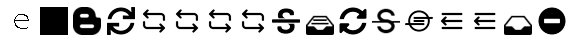

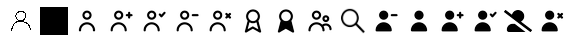

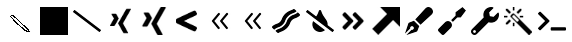

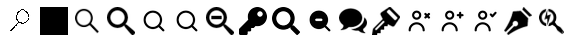

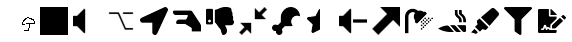

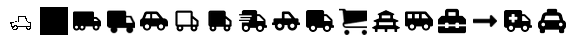

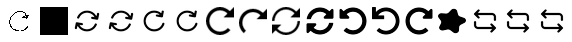

In [0]:

#target_im = paint_brush_img(w=input_size[0], h=input_size[1], line_width=30, preprocessed=True, show=False)
images = [cv2.imread(os.path.join(data_path, 'targets', im_path), 0) for im_path in os.listdir(os.path.join(data_path, 'targets')) if im_path.endswith('.jpg')]
images = [cv2.resize(i, (input_size[0], input_size[1])) for i in images]

for image in images:
  target_im = image

  target_im = np.expand_dims(data_preprocessing(target_im), axis=-1)

  #it should be commented...
  target_im_edges = target_im
  #target_im_edges = contour_img(target_im)

  res = manual_eval.get_n_most_similar_images(target_im_edges, _returnType='indexes')
  manual_eval.format_result(target_im, [X_icons_eval_edges[r] for r in res])

In [0]:
print("creating vector space...")
x_feat_test_icons = np.array([embedding_net.predict(f[np.newaxis, ...]) for f in x_test_icons])[:, 0, :]
x_feat_test_draws = np.array([embedding_net.predict(f[np.newaxis, ...]) for f in x_test_draws])[:, 0, :]

print("vector space created")

knn = KNN(x_feat_test_icons, y_test_icons, k=10)

y_test_icons_true = y_test_icons                                                # np.array_equal(y_test_icons,y_test_icons) is True
y_test_draws_pred = knn.get_labels(x_feat_test_draws)

get_score(y_test_icons_true, y_test_draws_pred)

